In [1]:

import os
import sys
import matplotlib.pyplot as plt

# Use os.getcwd() to get the current working directory
main_directory = os.getcwd()
parent_directory = os.path.dirname(main_directory)
parent_directory = os.path.dirname(parent_directory)


# Define the subdirectories you want to add to sys.path
subdirs = ['MaSeq', 'marcos_client']

# Add the subdirectories to sys.path
for subdir in subdirs:
    full_path = os.path.join(parent_directory, subdir)
    sys.path.append(full_path)
#******************************************************************************


In [2]:
import pypulseq as pp
import numpy as np
import seq.mriBlankSeq as blankSeq   
import configs.units as units
import scipy.signal as sig
import experiment_multifreq as ex
import configs.hw_config_pseq as hw
from flocra_pulseq.interpreter_pseq import PseqInterpreter
from pypulseq.convert import convert
class SRT1PSEQ(blankSeq.MRIBLANKSEQ):
    def __init__(self,
        seqName='SRT',
        nScans=4,
        larmorFreq=10.35595,
        rfExFA=90,
        # rfReFA=180,
        rfExTime=20.0,
        # rfReTime=40.0,
        # echoSpacing=0.2,
        repetitionTime=3000,
        nPoints=10,
        filterWindowSize=10,
        # etl=2048,
        bandwidth=426.666667,
        shimming=[0.0, 0.0, 0.0],
        Exphase=[0, 180, 90, 270],
        Refphase=[90, 90, 180, 180],
        Rxphase=[0, 180, 90, 270],
        # RxTimeOffset=0,
        txChannel=0,
        rxChannel=0,
        saturationPulseqNum=10,
        saturationIntervalDecay=0.29,
        firstInterval=100,
        inversionTime=100,
        deadTime=500,
    ):
        super(SRT1PSEQ, self).__init__()
        # Assign parameters from input arguments
        self.output = None
        self.expt =  None

        self.seqName = seqName
        self.nScans = nScans
        self.larmorFreq = larmorFreq
        self.rfExFA = rfExFA
        # self.rfReFA = rfReFA
        self.rfExTime = rfExTime
        # self.rfReTime = rfReTime
        # self.echoSpacing = echoSpacing
        self.repetitionTime = repetitionTime
        self.nPoints = nPoints
        self.filterWindowSize = filterWindowSize
        # self.etl = etl
        self.bandwidth = bandwidth
        self.acqTime = None
        self.shimming = shimming
        self.Exphase = Exphase
        self.Refphase = Refphase
        self.Rxphase = Rxphase
        # self.RxTimeOffset = RxTimeOffset
        self.txChannel = txChannel
        self.rxChannel = rxChannel

        self.saturationPulseqNum = saturationPulseqNum
        self.saturationIntervalDecay = saturationIntervalDecay
        self.firstInterval = firstInterval
        self.inversionTime = inversionTime
        self.deadTime = deadTime
        self.addParameter(key='seqName', string='CPMGInfo', val=self.seqName)
        self.addParameter(key='nScans', string='Number of scans', val=self.nScans, field='SEQ')
        self.addParameter(key='larmorFreq', string='Larmor frequency (MHz)', val=self.larmorFreq, units=units.MHz, field='RF')
       
        # SR params:
        self.addParameter(key='saturationPulseqNum', string='Saturation pulse number', val=self.saturationPulseqNum, field='SEQ')
        self.addParameter(key='saturationIntervalDecay', string='Saturation interval decay', val=self.saturationIntervalDecay, field='SEQ')
        self.addParameter(key='firstInterval', string='1st saturation interval (ms)', val=self.firstInterval, units=units.ms, field='SEQ')
        self.addParameter(key='inversionTime', string='Inversion time (ms)', val=self.inversionTime, units=units.ms, field='SEQ')
        
        # CPMG params
        self.addParameter(key='rfExFA', string='Excitation flip angle (deg)', val=self.rfExFA, field='RF')
        # self.addParameter(key='rfReFA', string='Refocusing flip angle (deg)', val=self.rfReFA, field='RF')
        self.addParameter(key='repetitionTime', string='Repetition time (ms)', val=self.repetitionTime, units=units.ms, field='SEQ')
        self.addParameter(key='rfExTime', string='RF excitation time (us)', val=self.rfExTime, units=units.us, field='RF')
        # self.addParameter(key='rfReTime', string='RF refocusing time (us)', val=self.rfReTime, units=units.us, field='RF')
        self.addParameter(key='deadTime', string='Dead time (us)', val=deadTime, units=units.us, field='RF')
        # self.addParameter(key='echoSpacing', string='Echo spacing (ms)', val=self.echoSpacing, units=units.ms, field='SEQ')
        self.addParameter(key='nPoints', string='Number of acquired points', val=self.nPoints, field='IM')
        self.addParameter(key='filterWindowSize', string='Filter Window Size', val=self.filterWindowSize, field='IM')
        # self.addParameter(key='etl', string='Echo train length', val=self.etl, field='SEQ')
        self.addParameter(key='bandwidth', string='Acquisition Bandwidth (kHz)', val=self.bandwidth, units=units.kHz, field='IM',
                          tip="The bandwidth of the acquisition (kHz). This value affects resolution and SNR.")
        self.addParameter(key='shimming', string='shimming', val=self.shimming, units=units.sh, field='OTH')
        self.addParameter(key='Exphase', string='Ex Phase (deg)', val=self.Exphase, tip='Excitation Phase Cycling', field='RF')
        # self.addParameter(key='Refphase', string='Ref Phase (deg)', val=self.Refphase, tip='Refocusing Phase Cycling', field='RF')
        self.addParameter(key='Rxphase', string='Rx Phase (deg)', val=self.Rxphase, tip='Rx Phase Cycling', field='RF')
        # self.addParameter(key='RxTimeOffset', string='Rx Time Offset (ms)', val=self.RxTimeOffset, units=units.ms, field='SEQ')
        self.addParameter(key='txChannel', string='Tx channel', val=self.txChannel, field='RF')
        self.addParameter(key='rxChannel', string='Rx channel', val=self.rxChannel, field='RF')
    def sequenceInfo(self):
        pass
        
    def sequenceTime(self):
        return (self.mapVals['repetitionTime'] *1e-3 * self.mapVals['nScans'] / 60)  # minutes

    def sequenceAtributes(self):
        super().sequenceAtributes()

    def sequenceRun(self, plotSeq=0, demo=False, standalone=False):
        init_gpa = False
        self.demo = demo
        self.plotSeq = plotSeq
        self.standalone = standalone

        max_grad_Hz = convert(from_value=hw.max_grad, from_unit='mT/m', gamma=hw.gammaB, to_unit='Hz/m')
        rfExTime_us = int(np.round(self.rfExTime * 1e6))
        # rfReTime_us = int(np.round(self.rfReTime * 1e6))
        assert rfExTime_us in hw.max_cpmg_rf_arr, f"RF excitation time '{rfExTime_us}' s is not found in the hw_config_pseq file; please search it in search_p90_pseq."
        # assert rfReTime_us in hw.max_cpmg_rf_p180_arr, f"RF refocusing time '{rfReTime_us}' s is not found in the hw_config_pseq file; please search it in search_p180_pseq."
        
        max_rf_Hz = hw.max_cpmg_rf_arr[rfExTime_us] * 1e-6 * hw.gammaB
        # rf_ref_correction_coeff = 0.5 * hw.max_cpmg_rf_arr[rfExTime_us] / hw.max_cpmg_rf_p180_arr[rfReTime_us]
        self.flo_interpreter = PseqInterpreter(
            tx_warmup=1,  # Transmit chain warm-up time (us)
            rf_center=hw.larmorFreq * 1e6 ,  # Larmor frequency (Hz)
            rf_amp_max=max_rf_Hz,  # Maximum RF amplitude (Hz)
            grad_max=max_grad_Hz,  # Maximum gradient amplitude (Hz/m)
            grad_t=10,  # Gradient raster time (us)
            grad_eff=hw.gradFactor, # gradient coefficient of efficiency
            tx_ch = self.txChannel,
            rx_ch = self.rxChannel,
            add_rx_points = 8,
            use_multi_freq=True,
        )
        assert (self.txChannel == 0 or self.txChannel == 1)
        assert (self.rxChannel == 0 or self.rxChannel == 1)
        self.rxChName = 'rx0' if (self.rxChannel == 0) else 'rx1'
        self.mapVals['rxChName'] = 'rx0'

        self.system = pp.Opts(
            rf_dead_time=1 * 1e-6,  # Dead time between RF pulses (s)
            rf_ringdown_time= 0 * 1e-6,
            max_grad=30,  # Maximum gradient strength (mT/m)
            grad_unit='mT/m',  # Units of gradient strength
            max_slew=hw.max_slew_rate,  # Maximum gradient slew rate (mT/m/ms)
            slew_unit='mT/m/ms',  # Units of gradient slew rate
            grad_raster_time=hw.grad_raster_time,  # Gradient raster time (s)
            rise_time=hw.grad_rise_time,  # Gradient rise time (s)
            rf_raster_time=0.25e-6,
            block_duration_raster=0.25e-6,
            adc_raster_time=1/(122.88e6)
        )

        bw = self.bandwidth * 1e-6 # MHz
        bw_ov = bw
        sampling_period = 1 / bw_ov  # us, Dwell time

        if not self.demo:
            expt = ex.Experiment(
                lo_freq=hw.larmorFreq,  # Larmor frequency in MHz
                rx_t=sampling_period,  # Sampling time in us
                init_gpa=False,  # Whether to initialize GPA board (False for True)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs (False or True)
            )
            sampling_period = expt.get_rx_ts()[0]  # us
            bw = 1 / sampling_period # / hw.oversamplingFactor  # MHz
            print("Acquisition bandwidth fixed to: %0.3f kHz" % (bw * 1e3))
            expt.__del__()
        self.mapVals['bw_MHz'] = bw
        self.mapVals['sampling_period_us'] = sampling_period
        self.mapVals['acqTime'] = self.nPoints / bw * 1e-3 # ms

        readout_duration = sampling_period * 1e-6 * self.nPoints

        readout_duration_rounded = np.ceil(sampling_period * self.nPoints * 4) / 4 * 1e-6
        if not self.demo:
            print(f'dwell time: {sampling_period} us, readout time: {readout_duration} s')
        
        RealExphase = np.tile(self.Exphase, int(np.ceil(self.nScans / len(self.Exphase))))
        # RealRefphase = np.tile(self.Refphase, int(np.ceil(self.nScans / len(self.Refphase))))
        RealRxphase = np.tile(self.Rxphase, int(np.ceil(self.nScans / len(self.Rxphase))))
        

        rf_ex = pp.make_block_pulse(
            flip_angle=self.rfExFA * np.pi / 180,
            duration=self.rfExTime,
            system=self.system,
            phase_offset=RealExphase[0] * np.pi / 180,
            delay=0,
        )
        # rf_ref = pp.make_block_pulse(
        #     flip_angle=self.rfReFA * np.pi / 180,
        #     duration=self.rfReTime,
        #     system=self.system,
        #     phase_offset=RealRefphase[0] * np.pi / 180,
        #     delay=0,
        # )
        # SR seq design:
        decay_array_time = self.firstInterval * (self.saturationIntervalDecay ** np.arange(self.saturationPulseqNum))
        decay_array = np.round(decay_array_time*1e6) / 1e6 
        SR_recovery_delay = self.inversionTime - self.rfExTime - (self.system.rf_dead_time + self.system.rf_ringdown_time)
        assert np.all(decay_array > 0), f"Error: decay_array contains non-positive values: {decay_array}"
        assert (SR_recovery_delay > 0), f"Error: SR_recovery_delay is a non-positive value: {SR_recovery_delay}"



        # correct p180:
        # rf_ref.signal = rf_ref_correction_coeff * rf_ref.signal 

        adc = pp.make_adc(num_samples=self.nPoints, duration=readout_duration) 
        # delay_te1 = np.round((0.5 * (self.echoSpacing - self.rfExTime - self.rfReTime) - (self.system.rf_dead_time+self.system.rf_ringdown_time))
        #                       / self.system.block_duration_raster) * self.system.block_duration_raster   
        # delay_te2 = np.round((0.5 * (self.echoSpacing - self.rfReTime - readout_duration_rounded) - self.system.rf_ringdown_time)
        #                       / self.system.block_duration_raster) * self.system.block_duration_raster
        # delay_te3 = np.round((0.5 * (self.echoSpacing - self.rfReTime - readout_duration_rounded) - self.system.rf_dead_time) 
        #                       / self.system.block_duration_raster) * self.system.block_duration_raster
        # delay_te2_with_offset = np.round((delay_te2 + self.RxTimeOffset) / self.system.block_duration_raster) * self.system.block_duration_raster
        # delay_te3_with_offset = np.round((delay_te3 - self.RxTimeOffset) / self.system.block_duration_raster) * self.system.block_duration_raster
        dead_time_period = self.deadTime
        recovery_time = np.round((self.repetitionTime - (0.5 * self.rfExTime + self.system.rf_dead_time 
                      + dead_time_period + np.sum((decay_array[:-1] + self.rfExTime + self.system.rf_dead_time + self.system.rf_ringdown_time)) + self.inversionTime
                      + 0 + np.round(0.5 * readout_duration_rounded * 1e6) / 1e6))
                      / self.system.block_duration_raster) * self.system.block_duration_raster
        # Assertions to check if times are greater than zero
        assert recovery_time > 0, f"Error: recovery_time is non-positive: {recovery_time}"
        
        # if self.etl == 1: # for debuging
        #     delay_te2 = 10e-6 
        #     delay_te3 = 10e-6 
        #     delay_te2_with_offset = delay_te2
        #     delay_te3_with_offset = delay_te3
        # else:
        #     assert delay_te2 > 0, f"Error: delay_te2 is non-positive: {delay_te2}"
        #     assert delay_te3 > 0, f"Error: delay_te3 is non-positive: {delay_te3}"
        #     assert delay_te2_with_offset > 0, f"Error: delay_te2_with_offset is non-positive: {delay_te2_with_offset}"
        #     assert delay_te3_with_offset > 0, f"Error: delay_te3_with_offset is non-positive: {delay_te3_with_offset}"
        
        acq_points = 0
        seq = pp.Sequence(system=self.system)
        for scan in range(self.nScans):
            # Phase Cycling
            rf_ex.phase_offset = RealExphase[scan] * np.pi / 180
            adc.phase_offset = RealRxphase[scan] * np.pi / 180
            # rf_ref.phase_offset = RealRefphase[scan] * np.pi / 180

            # SR pulse
            for SRindex in range(self.saturationPulseqNum-1):
                seq.add_block(rf_ex)
                seq.add_block(pp.make_delay(decay_array[SRindex]))
            seq.add_block(rf_ex)
            seq.add_block(pp.make_delay(SR_recovery_delay))

            # Excitation pulse
            seq.add_block(rf_ex)
            seq.add_block(pp.make_delay(dead_time_period))
            
            seq.add_block(adc, pp.make_delay(readout_duration_rounded))
               
            if not scan == self.nScans-1: 
                seq.add_block(pp.make_delay(recovery_time))

        if plotSeq:
            # Check whether the timing of the sequence is correct
            ok, error_report = seq.check_timing()
            if ok:
                print("Timing check passed successfully")
            else:
                print("Timing check failed. Error listing follows:")
                [print(e) for e in error_report]   

            seq.plot(show_blocks =True)

        seq.set_definition(key="Name", value="SRT1")
        seq.write("SRT1.seq")
        self.waveforms, param_dict = self.flo_interpreter.interpret("SRT1.seq")
         
        larmorFreq = self.mapVals['larmorFreq']
        if not self.demo:
            self.expt = ex.Experiment(
                lo_freq=(self.larmorFreq + 0) * 1e-6,  # Larmor frequency in MHz
                rx_t= sampling_period,
                init_gpa=False,  # Whether to initialize GPA board (False for now)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs
            )
        print(f"Center frequecy set: {(self.larmorFreq + 0) * 1e-6} MHz")
        # Convert the PyPulseq waveform to the Red Pitaya compatible format
        self.pypulseq2mriblankseqV2(waveforms=self.waveforms, shimming=self.shimming)
        
        # Load the waveforms into Red Pitaya
        if not self.floDict2Exp_ms():
            print("ERROR: Sequence waveforms out of hardware bounds")
            return False
        else:
            encoding_ok = True
            # print("Sequence waveforms loaded successfully")

        if self.plotSeq and self.standalone:
            # Plot the sequence if requested and return immediately
            self.expt.plot_sequence()
            self.sequencePlot(standalone=self.standalone)
            
        data_over = []
         
        # If not plotting the sequence, start scanning
        if not self.plotSeq:
            # for scan in range(self.nScans):
            if True:
                print(f"Scan running...")
                acquired_points = 0
                expected_points = self.nPoints * 1 * self.nScans  # Expected number of points

                # Continue acquiring points until we reach the expected number
                while acquired_points != expected_points:
                    if not self.demo:
                        rxd, msgs = self.expt.run()  # Run the experiment and collect data
                    else:
                        # In demo mode, generate random data as a placeholder
                        rxd = {self.rxChName: np.random.randn(expected_points + self.flo_interpreter.get_add_rx_points()) + 1j * np.random.randn(expected_points + + self.flo_interpreter.get_add_rx_points())}
                    # Update acquired points
                    rx_raw_data = rxd[self.rxChName]
                    add_rx_points = self.flo_interpreter.get_add_rx_points()
                    before_delete = np.reshape(rx_raw_data, newshape=(1 * self.nScans, -1))
                    rxdataremove = before_delete[:, add_rx_points:]
                    rxdata = np.reshape(rxdataremove, newshape=(-1))
                    acquired_points = np.size(rxdata)


                    # Check if acquired points coincide with expected points
                    if acquired_points != expected_points:
                        print("WARNING: data apoints lost!")
                        print("Repeating batch...")

                # Concatenate acquired data into the oversampled data array
                data_over = np.concatenate((data_over, rxdata), axis=0)
                print(f"Acquired points = {acquired_points}, Expected points = {expected_points}")
                print(f"Scan ready!")
                # plt.plot(data_over)
                # plt.show()
            # Decimate the oversampled data and store it
            self.mapVals['data_over'] = data_over

            # Average data
            # data = np.average(np.reshape(data_over, (self.nScans, -1)), axis=0)
            self.mapVals['data'] = data_over

        

        if not self.demo:
            self.expt.__del__()

        self.mapVals['n_readouts'] = self.nPoints
        return True

        


    def sequenceAnalysis(self, mode=None):
        
        def getFHWM(s,f_vector,bw):
            target = np.max(s) / 2
            p0 = np.argmax(s)
            f0 = f_vector[p0]
            s1 = np.abs(s[0:p0]-target)
            f1 = f_vector[np.argmin(s1)]
            s2 = np.abs(s[p0::]-target)
            f2 = f_vector[np.argmin(s2)+p0]
            return f2-f1

        self.mode = mode
        # Signal and spectrum from 'fir' and decimation
        self.mapVals['etl'] = 1

        # [TODO]: Add Rx phase here
        if True:
            rawdata = self.mapVals['data']
            chName = self.mapVals['rxChName']
            expiangle = self.flo_interpreter.get_rx_phase_dict()[chName]
            raw_data_reshape = np.reshape(rawdata, newshape=(-1, self.mapVals['nPoints']))
            
            for line in range(raw_data_reshape.shape[0]):
                raw_data_reshape[line, :] = raw_data_reshape[line, :] * expiangle[line]
            signal = np.reshape(raw_data_reshape, -1)
        else: 
            signal = self.mapVals['data']


        # Average data
        signal = np.average(np.reshape(signal, (self.nScans, -1)), axis=0)

          
        # average filter
        bw = self.mapVals['bw_MHz']*1e3 # kHz
        nPoints = self.mapVals['nScans'] * self.mapVals['nPoints'] * self.mapVals['etl']
        deadTime = 0 #self.mapVals['deadTime']*1e-3 # ms
        rfRectExTime = self.mapVals['rfExTime']*1e-3 # ms
        

        def create_tVector(bw, nPoint, echoSpacing, etl, RFinterval = False):
            point_interval = 1 / bw
            # window_duration = nPoint * point_interval
            start_times = np.arange(0, etl * echoSpacing, echoSpacing)
            if RFinterval:
                tVector = np.concatenate([start_time + np.arange(nPoint) * point_interval for start_time in start_times])
            else:
                tVector = np.reshape([np.arange(nPoint * etl) * point_interval], newshape=(-1))
            return tVector

        #tVector = np.linspace(rfRectExTime/2 + deadTime + 0.5/bw, rfRectExTime/2 + deadTime + (nPoints-0.5)/bw, nPoints)
        tVector = create_tVector(bw * 1e3, self.mapVals['nPoints'], 1, self.mapVals['etl'])
        tVecRes = np.reshape(tVector, newshape=(-1, self.mapVals['nPoints']))
        
        fir_coefficients = np.ones(self.mapVals['filterWindowSize']) / self.mapVals['filterWindowSize']
        num_taps = len(fir_coefficients)
        signal_waiting_for_filters = np.reshape(signal, newshape=(-1, self.mapVals['nPoints']))
        output_length = signal_waiting_for_filters.shape[1] - num_taps + 1
        filtered = np.zeros((signal_waiting_for_filters.shape[0], output_length), dtype=complex)
        filtered_time = np.zeros((signal_waiting_for_filters.shape[0], output_length))

        for i in range(signal_waiting_for_filters.shape[0]):
            real_filtered = np.convolve(signal_waiting_for_filters[i].real, fir_coefficients, mode='valid')
            imag_filtered = np.convolve(signal_waiting_for_filters[i].imag, fir_coefficients, mode='valid')
            filtered[i] = real_filtered + 1j * imag_filtered
            filtered_time[i] = tVecRes[i, num_taps - 1:] 
        filtered_signal = np.reshape(filtered, newshape=(-1))
        # filtered_time_vector = np.reshape(filtered_time, newshape=(-1))
        filtered_time_vector = np.array([self.mapVals['inversionTime']])

        fVector = np.linspace(-bw/2, bw/2, nPoints)
        spectrum = np.abs(np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(signal))))
        fitedLarmor=self.mapVals['larmorFreq'] - fVector[np.argmax(np.abs(spectrum))] * 1e-3  #MHz
        # hw.larmorFreq=fitedLarmor
        # print(f"self{self.larmorFreq}, map{self.mapVals['larmorFreq'] }, fv{fVector[np.argmax(np.abs(spectrum))]},fit larmor{fitedLarmor}")
        # fwhm=getFHWM(spectrum, fVector, bw)
        # dB0=fwhm*1e6/fitedLarmor


        # t_filtered = tVector[:filtered_signal.shape[0]]

        # for sequence in self.sequenceList.values():
        #     if 'larmorFreq' in sequence.mapVals:
        #         sequence.mapVals['larmorFreq'] = hw.larmorFreq
        self.mapVals['larmorFreq'] = fitedLarmor

        # Get the central frequency
        print('Larmor frequency: %1.5f MHz' % fitedLarmor)
        # print('FHWM: %1.5f kHz' % fwhm)
        # print('dB0/B0: %1.5f ppm' % dB0)

        self.mapVals['signalVStime'] = [tVector, signal]
        self.mapVals['spectrum'] = [fVector, spectrum]

        # Add time signal to the layout
        result1 = {'widget': 'curve',
                   'xData': tVector,
                   'yData': [np.abs(signal), np.real(signal), np.imag(signal)],
                   'xLabel': 'Time (ms)',
                   'yLabel': 'Signal amplitude',
                   'title': 'Signal vs time',
                   'legend': ['abs', 'real', 'imag'],
                   'row': 0,
                   'col': 0}

        # # Add frequency spectrum to the layout
        # result2 = {'widget': 'curve',
        #            'xData': tVector,#fVector,
        #            'yData': [np.angle(signal)], #[spectrum],
        #            'xLabel': 'Time (ms)',
        #            'yLabel': 'Angle (rad)',
        #            'title': 'Angle',
        #            'legend': [''],
        #            'row': 1,
        #            'col': 0}
        
        result2 = {'widget': 'curve',
                   'xData': filtered_time_vector,
                   'yData': [np.abs(filtered_signal), np.real(filtered_signal), np.imag(filtered_signal)],
                   'xLabel': 'Time (ms)',
                   'yLabel': 'Filtered signal amplitude',
                   'title': 'Signal vs time',
                   'legend': ['abs', 'real', 'imag'],
                   'row': 1,
                   'col': 0}

        self.mapVals['filtered_signalVStime'] = [filtered_time_vector,filtered_signal]

        # create self.out to run in iterative mode
        self.output = [result1, result2]
        self.saveRawData()

        if self.mode == 'Standalone':
            self.plotResults()
        return self.output
     

/home/lks/.local/lib/python3.12/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(
/home/lks/.local/lib/python3.12/site-packages/cupy/_environment.py:445: UserWarning: 
nccl library could not be loaded.

Reason: ImportError (libnccl.so.2: cannot open shared object file: No such file or directory)

You can install the library by:
  $ python -m cupyx.tools.install_library --library nccl --cuda 12.x

  warnings.warn(f'''
/home/lks/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sequence total time: 0.0 min 8.0 seconds!
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...


/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are

Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_111907 to experiments/acquisitions/2025.06.24


/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


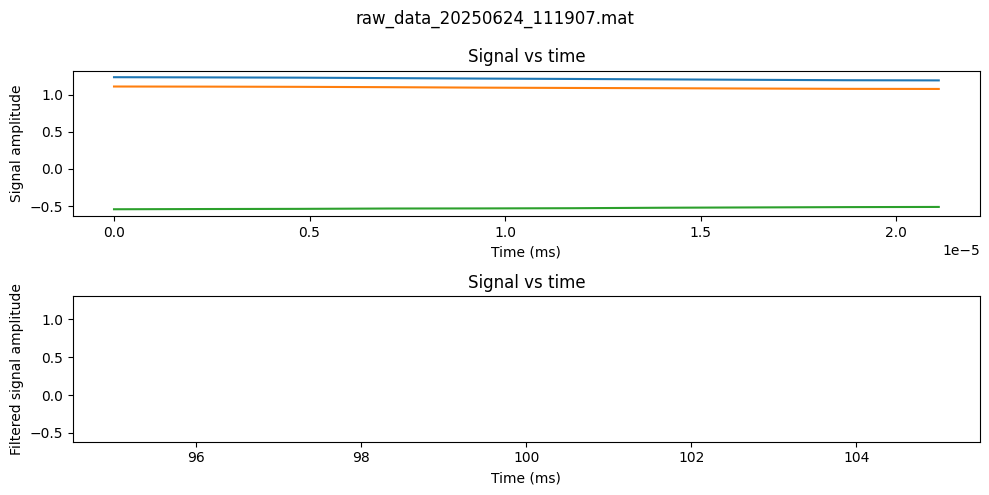

------------ max abs value: 1.2169362608270868


In [3]:
seq = SRT1PSEQ(
        seqName='SRT1',
        nScans=4,
        larmorFreq=10.33350,
        rfExFA=90,
        rfExTime=30.0,
        repetitionTime=2000,
        nPoints=10,
        filterWindowSize=10,
        bandwidth=426.666667,
        shimming=[0.0, 0.0, 0.0],
        Exphase=[0, 180, 90, 270],
        Refphase=[90, 90, 180, 180],
        Rxphase=[0, 180, 90, 270],
        txChannel=0,
        rxChannel=0,
        saturationPulseqNum=10,
        saturationIntervalDecay=0.29,
        firstInterval=100,
        inversionTime=100,
        deadTime=50,
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!")
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
seq.sequenceAnalysis(mode='Standalone')
print(f'------------ max abs value: {np.abs(seq.mapVals["filtered_signalVStime"][1]).max()}')

In [4]:
seq.mapVals['filtered_signalVStime'] 


[array([100]), array([1.42126629-0.39848241j])]

In [4]:
import numpy as np

def calculate_repeat_para(nType, m_Min, m_Max, Counts):
    """
    Calculate Repeat_Para based on nType using numpy.
    
    Parameters:
        nType (int): Type of calculation (1 for FFG TE^3, 2 for PFG G^2, 3 for SR-CPMG, 4 for T2-T2)
        m_Min (float): Minimum value
        m_Max (float): Maximum value
        Counts (int): Number of steps
    
    Returns:
        numpy.ndarray: Array of Repeat_Para values
    """
    indices = np.arange(Counts)  # Create indices from 0 to Counts - 1
    Repeat_Para = np.zeros(Counts)  # Initialize Repeat_Para array

    if nType == 1:  # FFG TE^3
        min3 = m_Min ** 3
        max3 = m_Max ** 3
        values = 10 ** (((np.log10(max3) - np.log10(min3)) / (Counts - 1)) * indices + np.log10(min3))
        Repeat_Para = np.ceil(values ** (1 / 3))  # Apply cube root and round up

    elif nType == 2:  # PFG G^2
        min2 = m_Min ** 2
        max2 = m_Max ** 2
        values = 10 ** (((np.log10(max2) - np.log10(min2)) / (Counts - 1)) * indices + np.log10(min2))
        Repeat_Para = np.floor(values ** (1 / 2))  # Apply square root and round down

    elif nType == 3:  # SR-CPMG
        values = 10 ** (((np.log10(m_Max) - np.log10(m_Min)) / (Counts - 1)) * indices + np.log10(m_Min))
        Repeat_Para = np.floor(values)  # Round down

    elif nType == 4:  # T2-T2
        values = 10 ** (((np.log10(m_Max) - np.log10(m_Min)) / (Counts - 1)) * indices + np.log10(m_Min))
        Repeat_Para = np.floor(values)  # Round down

    return Repeat_Para.astype(int)  # Return as integer array

# Example usage
# nType = 4
# m_Min = 200
# m_Max = 1500000
# Counts = 5

# result = calculate_repeat_para(nType, m_Min, m_Max, Counts)
# print("Repeat_Para:", result)


Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...


/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are

Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112000 to experiments/acquisitions/2025.06.24


/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


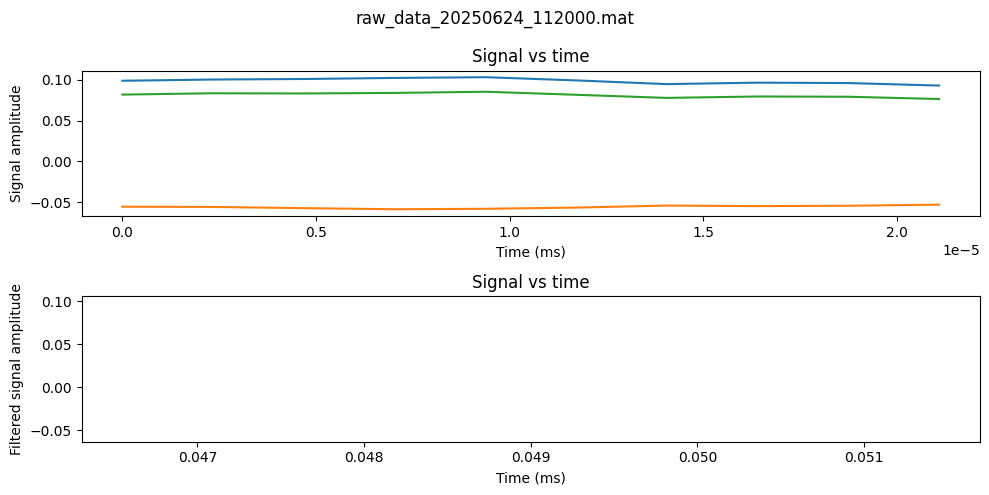

/tmp/ipykernel_935626/26763131.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filteredsignal[rindex, 0] = seq.mapVals['filtered_signalVStime'][0]
/tmp/ipykernel_935626/26763131.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filteredsignal[rindex, 1] = np.abs(seq.mapVals['filtered_signalVStime'][1])


-----TIval above: 0.049 ms------- max abs value: 0.09815775216171803
---->>>TIval: [0.049] ms------- max abs value: [0.09815775]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112009 to experiments/acquisitions/2025.06.24


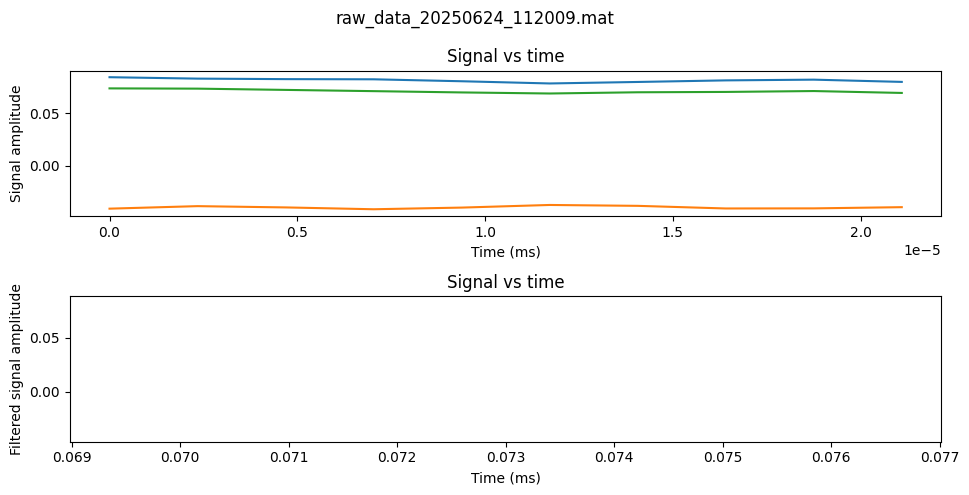

-----TIval above: 0.073 ms------- max abs value: 0.08180814531236605
---->>>TIval: [0.073] ms------- max abs value: [0.08180815]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112019 to experiments/acquisitions/2025.06.24


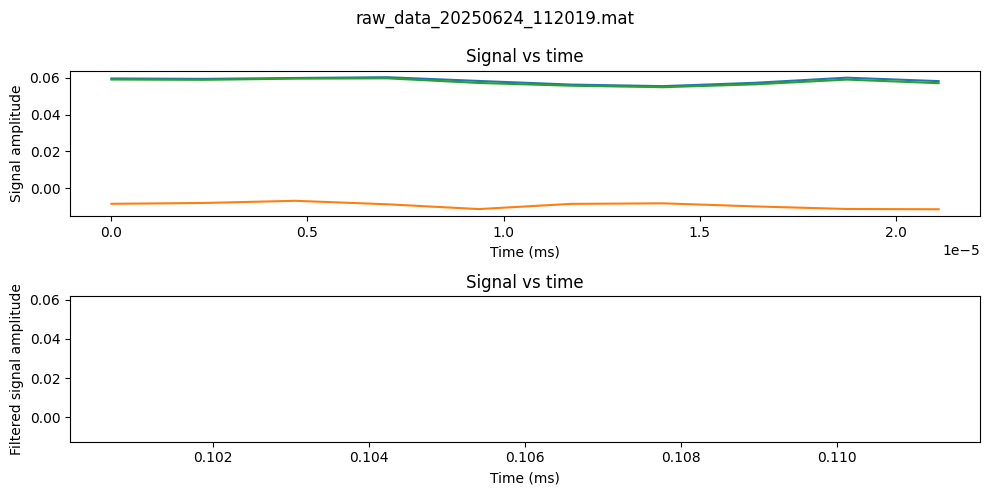

-----TIval above: 0.106 ms------- max abs value: 0.05836746432207544
---->>>TIval: [0.106] ms------- max abs value: [0.05836746]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112029 to experiments/acquisitions/2025.06.24


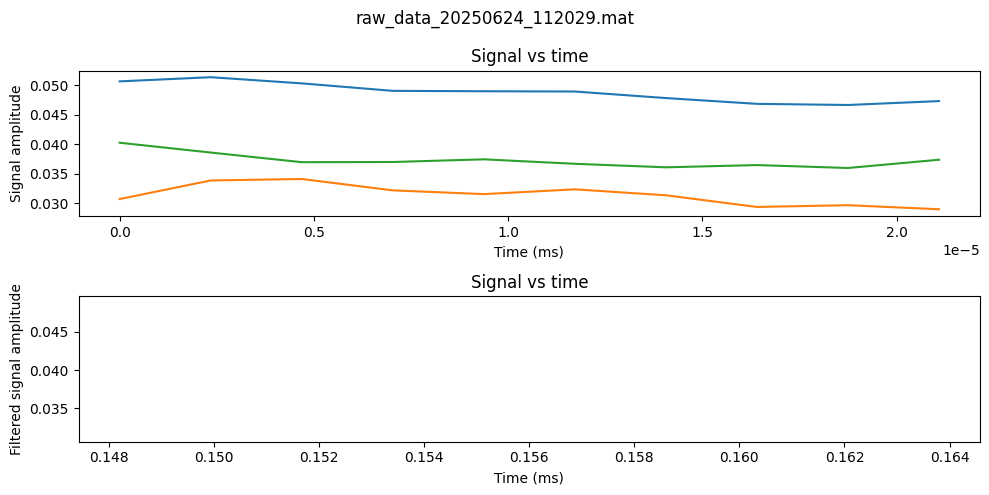

-----TIval above: 0.156 ms------- max abs value: 0.048799722544299345
---->>>TIval: [0.156] ms------- max abs value: [0.04879972]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112038 to experiments/acquisitions/2025.06.24


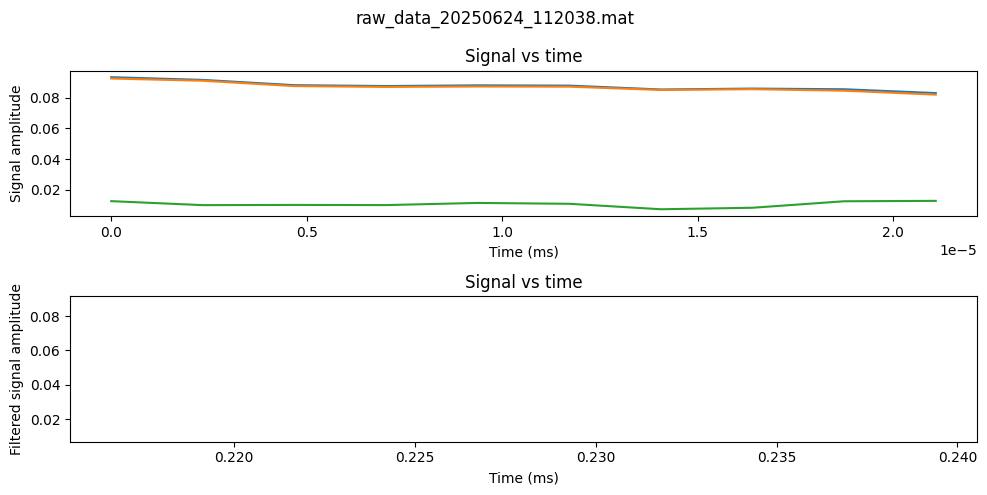

-----TIval above: 0.228 ms------- max abs value: 0.08756759791782727
---->>>TIval: [0.228] ms------- max abs value: [0.0875676]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112047 to experiments/acquisitions/2025.06.24


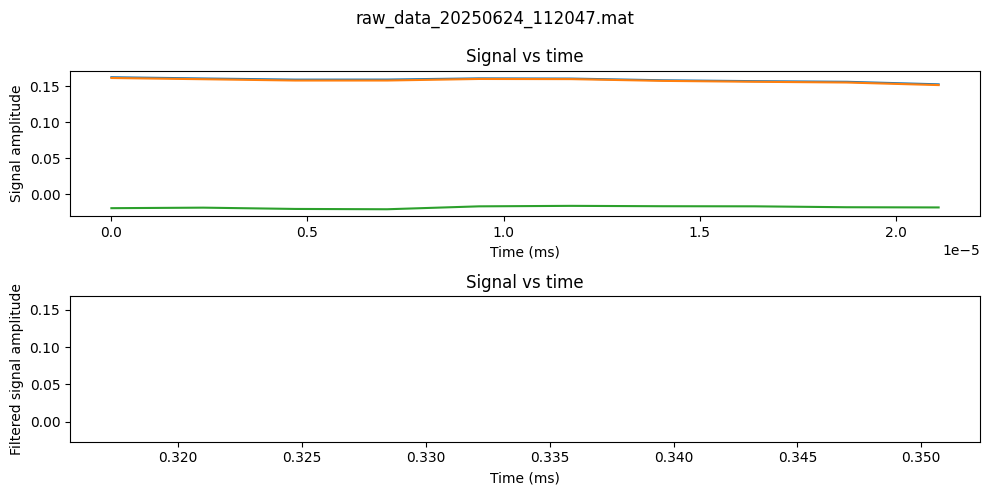

-----TIval above: 0.334 ms------- max abs value: 0.1589986531293184
---->>>TIval: [0.334] ms------- max abs value: [0.15899865]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112057 to experiments/acquisitions/2025.06.24


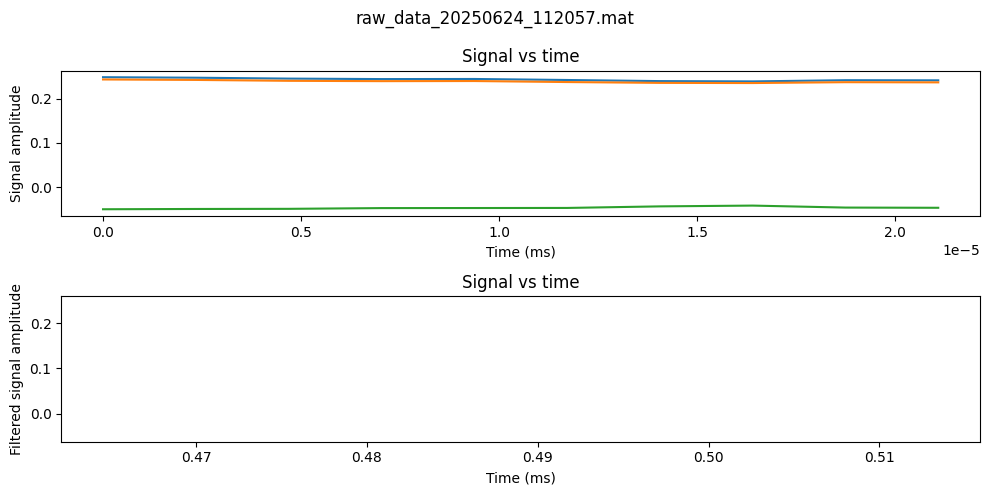

-----TIval above: 0.489 ms------- max abs value: 0.24402157609325123
---->>>TIval: [0.489] ms------- max abs value: [0.24402158]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112106 to experiments/acquisitions/2025.06.24


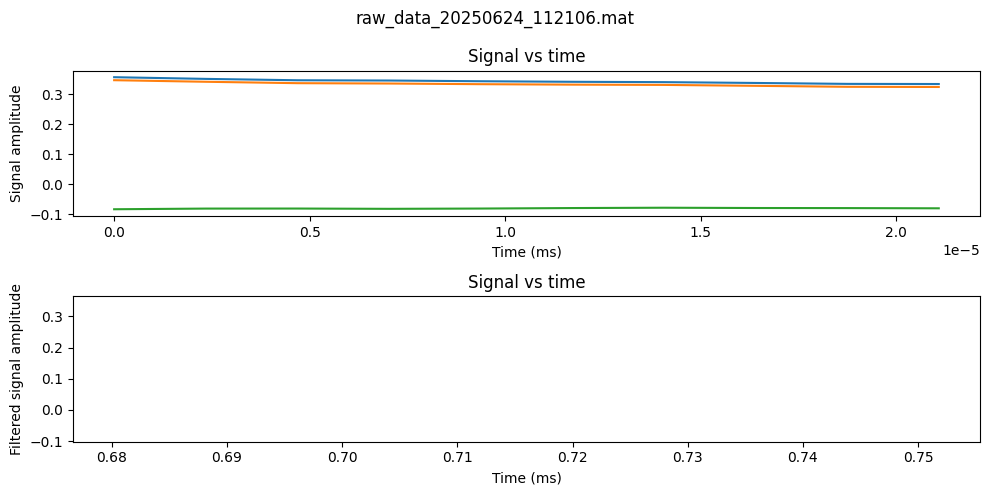

-----TIval above: 0.716 ms------- max abs value: 0.3424762515848406
---->>>TIval: [0.716] ms------- max abs value: [0.34247625]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112115 to experiments/acquisitions/2025.06.24


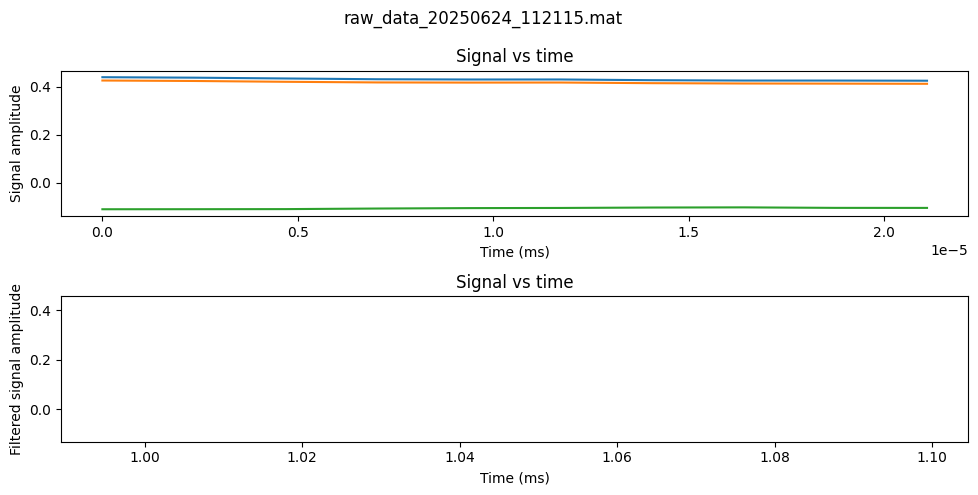

-----TIval above: 1.047 ms------- max abs value: 0.4300556032577665
---->>>TIval: [1.047] ms------- max abs value: [0.4300556]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112125 to experiments/acquisitions/2025.06.24


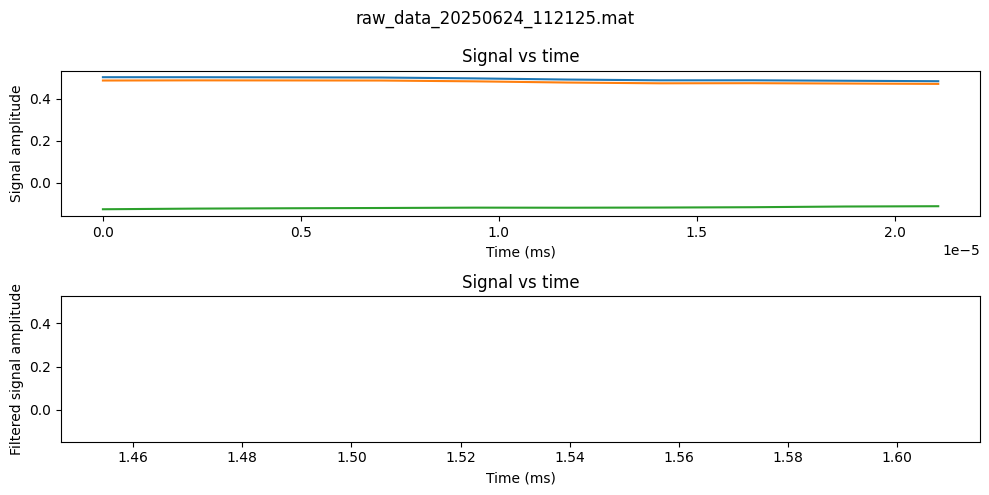

-----TIval above: 1.5310000000000001 ms------- max abs value: 0.4933182957661473
---->>>TIval: [1.531] ms------- max abs value: [0.4933183]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112134 to experiments/acquisitions/2025.06.24


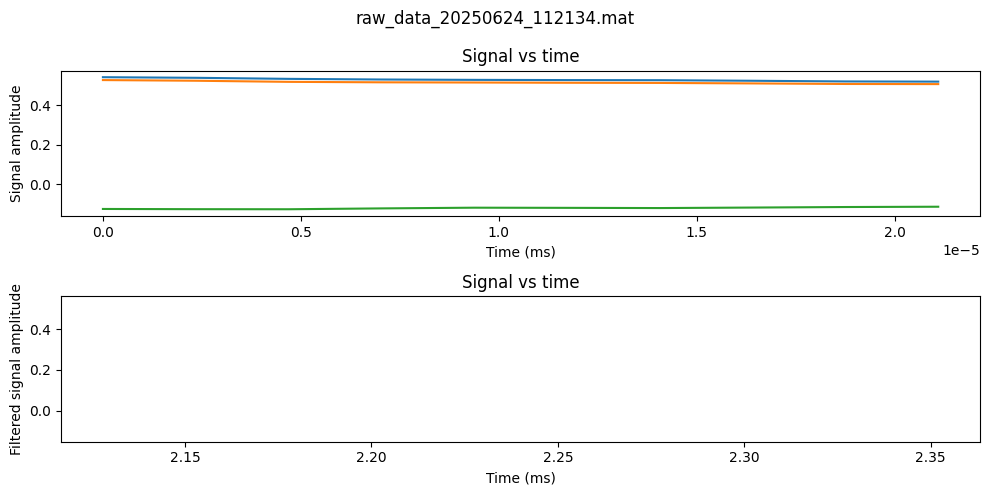

-----TIval above: 2.24 ms------- max abs value: 0.5282930304320431
---->>>TIval: [2.24] ms------- max abs value: [0.52829303]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112143 to experiments/acquisitions/2025.06.24


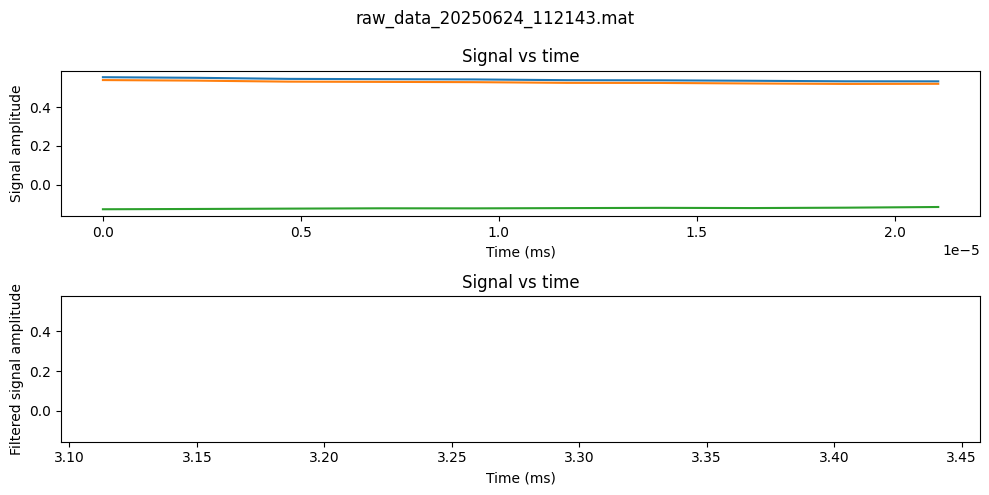

-----TIval above: 3.277 ms------- max abs value: 0.541233424044905
---->>>TIval: [3.277] ms------- max abs value: [0.54123342]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112152 to experiments/acquisitions/2025.06.24


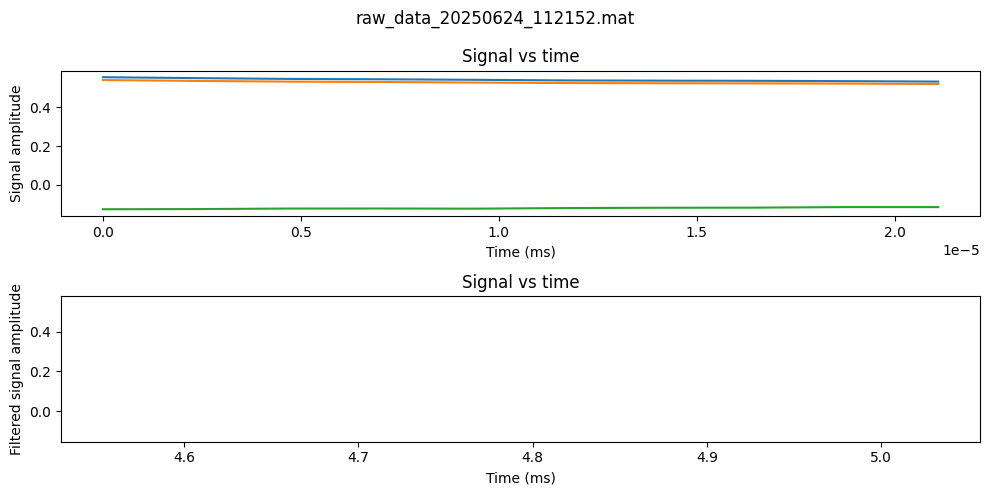

-----TIval above: 4.793 ms------- max abs value: 0.5433747179712736
---->>>TIval: [4.793] ms------- max abs value: [0.54337472]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112202 to experiments/acquisitions/2025.06.24


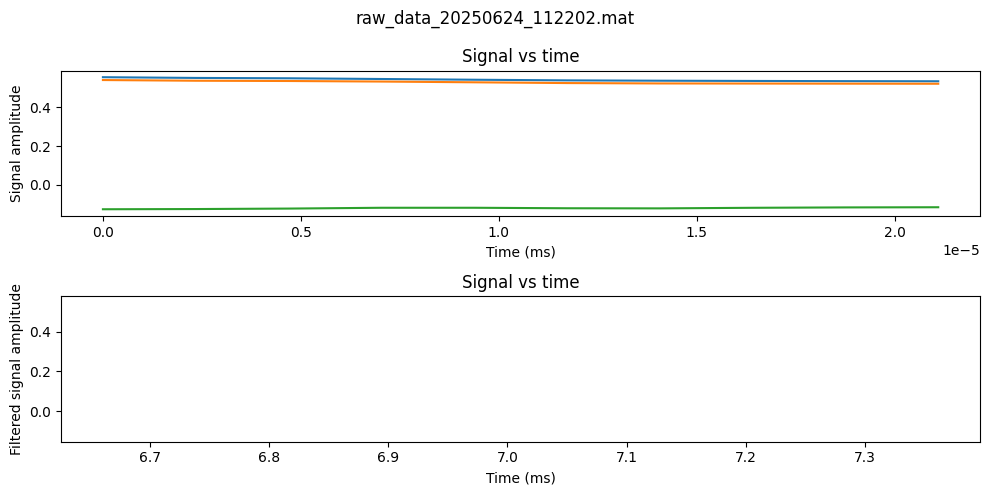

-----TIval above: 7.011 ms------- max abs value: 0.5435769779701313
---->>>TIval: [7.011] ms------- max abs value: [0.54357698]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112211 to experiments/acquisitions/2025.06.24


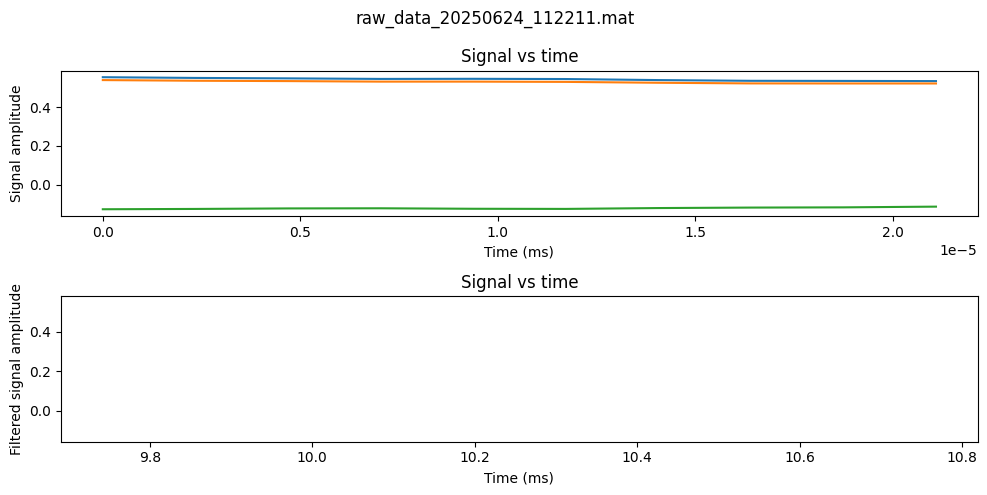

-----TIval above: 10.255 ms------- max abs value: 0.5439760186651743
---->>>TIval: [10.255] ms------- max abs value: [0.54397602]
Acquisition bandwidth fixed to: 426.667 kHz
dwell time: 2.34375 us, readout time: 2.3437499999999997e-05 s
read 5 definitions, 95 blocks, 3 shapes, 4 adc events, 4 rf events, 0 gradient shapes
Center frequecy set: 10.333499999999999 MHz
Scan running...
Acquired points = 40, Expected points = 40
Scan ready!
Larmor frequency: 10.49213 MHz
Moved: raw_data_20250624_112220 to experiments/acquisitions/2025.06.24


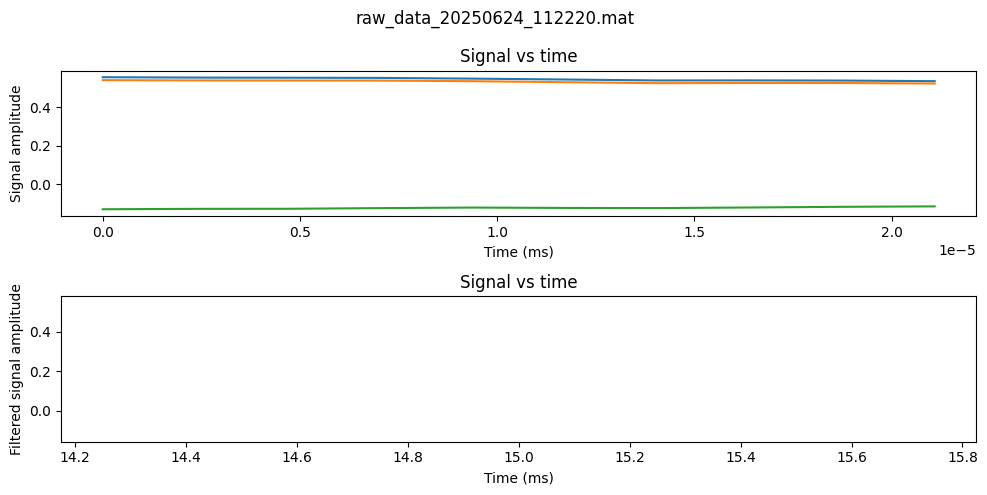

-----TIval above: 15.0 ms------- max abs value: 0.5455397075111641
---->>>TIval: [15.] ms------- max abs value: [0.54553971]


In [5]:
import time
import pandas as pd

count = 16
minValue = 50 #us
maxValue = 15000 #us
nType = 4 # for SR_T1T2
repeatPara = calculate_repeat_para(nType, minValue, maxValue, count)

init_params = {
    'seqName': 'SRT1',
    'nScans': 4,
    'larmorFreq': 10.33350,
    'rfExFA': 90,
    'rfExTime': 30.0,
    'repetitionTime': 3000,
    'nPoints': 10,
    'filterWindowSize': 10,
    'bandwidth': 426.666667,
    'shimming': [0.0, 0.0, 0.0],
    'Exphase': [0, 180, 90, 270],
    'Refphase': [90, 90, 180, 180],
    'Rxphase': [0, 180, 90, 270],
    'txChannel': 0,
    'rxChannel': 0,
    'saturationPulseqNum': 10,
    'saturationIntervalDecay': 0.29,
    'firstInterval': 100,
    'inversionTime': 100,
    'deadTime': 500,
}
# xls format:
# C2(5), TAU(520), MixedTime(5000), NS(8), RD(3000000)
# xlsPramsList = np.array([
#     5,
#     init_params['echoSpacing']*1000,
#     5000,
#     init_params['nScans'],
#     init_params['repetitionTime']*1000,
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,
#     0,
#     init_params['inversionTime']*1000,
# ])
# xlsvector_len = init_params['etl']
# extended_xlsvector = np.zeros(xlsvector_len)
# # extended_xlsvector[:14] = xlsPramsList
# extended_xlsvector = extended_xlsvector.reshape(xlsvector_len, 1)


# result = np.zeros((len(repeatPara), init_params['etl']),dtype=complex)
out_index = 0
out_data_mat = np.zeros((count, 2))
filteredsignal = np.zeros((count, 2), dtype=complex)
for rindex in range(len(repeatPara)):
    out_index = out_index + 1
    #print(repeatPara[rindex])
    init_params['inversionTime'] = repeatPara[rindex] * 1e-3
    seq = SRT1PSEQ(**init_params)
    seq.sequenceAtributes()
    seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
    seq.sequenceAnalysis(mode='Standalone')
    print(f'-----TIval above: {repeatPara[rindex] * 1e-3} ms------- max abs value: {np.abs(seq.mapVals["filtered_signalVStime"][1]).max()}')
    print(f'---->>>TIval: {seq.mapVals['filtered_signalVStime'][0]} ms------- max abs value: {np.abs(seq.mapVals["filtered_signalVStime"][1])}')
    out_data_mat[rindex, 0] = repeatPara[rindex] 
    out_data_mat[rindex, 1] = np.abs(seq.mapVals["filtered_signalVStime"][1]).max()
    filteredsignal[rindex, 0] = seq.mapVals['filtered_signalVStime'][0]
    filteredsignal[rindex, 1] = np.abs(seq.mapVals['filtered_signalVStime'][1])
    # result[rindex] = seq.mapVals['filtered_signalVStime'][1]

    # resultMat = np.column_stack(((np.arange(len(result[rindex]))*init_params['echoSpacing']*1000+init_params['echoSpacing']*1000), np.abs(result[rindex])))
    # extended_xlsvector[13] = repeatPara[rindex]
    # result_matrix = np.hstack((resultMat, extended_xlsvector))

    # df = pd.DataFrame(result_matrix, columns=['TE/us', 'Ampti', 'Param'])

    # # Write outputMat to a text file with tab-separated values
    # df.to_excel(f'spec_experiments/SRT1/T1water-{repeatPara[rindex]}.xlsx', index=False)

    time.sleep(.02)
# write out_data_mat to a .dat format
# np.savetxt('spec_experiments/SRT1/T1water.dat', out_data_mat, delimiter=',', fmt='%d')

In [7]:
filteredsignal

array([[1.00000000e+00+0.j, 4.90511999e-02+0.j],
       [1.62800000e+00+0.j, 4.84135730e-02+0.j],
       [2.65100000e+00+0.j, 1.71089612e-01+0.j],
       [4.31700000e+00+0.j, 2.76759918e-01+0.j],
       [7.03000000e+00+0.j, 3.95191333e-01+0.j],
       [1.14470000e+01+0.j, 6.10862263e-01+0.j],
       [1.86390000e+01+0.j, 8.37995862e-01+0.j],
       [3.03510000e+01+0.j, 1.11253537e+00+0.j],
       [4.94210000e+01+0.j, 1.33335990e+00+0.j],
       [8.04730000e+01+0.j, 1.45380158e+00+0.j],
       [1.31037000e+02+0.j, 1.48537653e+00+0.j],
       [2.13370000e+02+0.j, 1.48422102e+00+0.j],
       [3.47434000e+02+0.j, 1.48632252e+00+0.j],
       [5.65734000e+02+0.j, 1.48371252e+00+0.j],
       [9.21195000e+02+0.j, 1.48308433e+00+0.j],
       [1.50000000e+03+0.j, 1.48656218e+00+0.j]])

In [6]:
# data export
signal_pack = np.column_stack((np.abs(filteredsignal[:, 0])*1e-3, np.abs(filteredsignal[:, 1])))
# export to .dat
np.savetxt('SRT1water.dat', signal_pack, delimiter=',', fmt='%d')
print(signal_pack)

[[4.90000000e-05 9.81577522e-02]
 [7.30000000e-05 8.18081453e-02]
 [1.06000000e-04 5.83674643e-02]
 [1.56000000e-04 4.87997225e-02]
 [2.28000000e-04 8.75675979e-02]
 [3.34000000e-04 1.58998653e-01]
 [4.89000000e-04 2.44021576e-01]
 [7.16000000e-04 3.42476252e-01]
 [1.04700000e-03 4.30055603e-01]
 [1.53100000e-03 4.93318296e-01]
 [2.24000000e-03 5.28293030e-01]
 [3.27700000e-03 5.41233424e-01]
 [4.79300000e-03 5.43374718e-01]
 [7.01100000e-03 5.43576978e-01]
 [1.02550000e-02 5.43976019e-01]
 [1.50000000e-02 5.45539708e-01]]


In [10]:
def display_plot(FiltersignalVStime):
    from flintpy.flintpy import Flint, FlintSignal
    signal_decay = FiltersignalVStime[:, 1]
    time_axis = FiltersignalVStime[:, 0]
    print(signal_decay)
    print(time_axis)
    signal = FlintSignal.load_from_data(signal_decay, time_axis, None)
    flint = Flint(
        signal, kernel_shape=[1000, 1], kernel_name="T1SR", alpha=1e-1, t1range=[1e-6, 1e1], t2range=None
    )
    flint.solve_flint()

    # Generate and capture the Plotly figure from flint.plot()
    fig = flint.plot()
    print()
    fig.update_layout(
        xaxis=dict(
            tickvals=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
        )
    )
    # Display the updated plot
    fig.show()
    plt.show()
    # plot FilterSingal
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, signal_decay, marker='o')
    plt.grid(True)
    plt.title('Filtered Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')


[0.09815775 0.08180815 0.05836746 0.04879972 0.0875676  0.15899865
 0.24402158 0.34247625 0.4300556  0.4933183  0.52829303 0.54123342
 0.54337472 0.54357698 0.54397602 0.54553971]
[4.9000e-05 7.3000e-05 1.0600e-04 1.5600e-04 2.2800e-04 3.3400e-04
 4.8900e-04 7.1600e-04 1.0470e-03 1.5310e-03 2.2400e-03 3.2770e-03
 4.7930e-03 7.0110e-03 1.0255e-02 1.5000e-02]



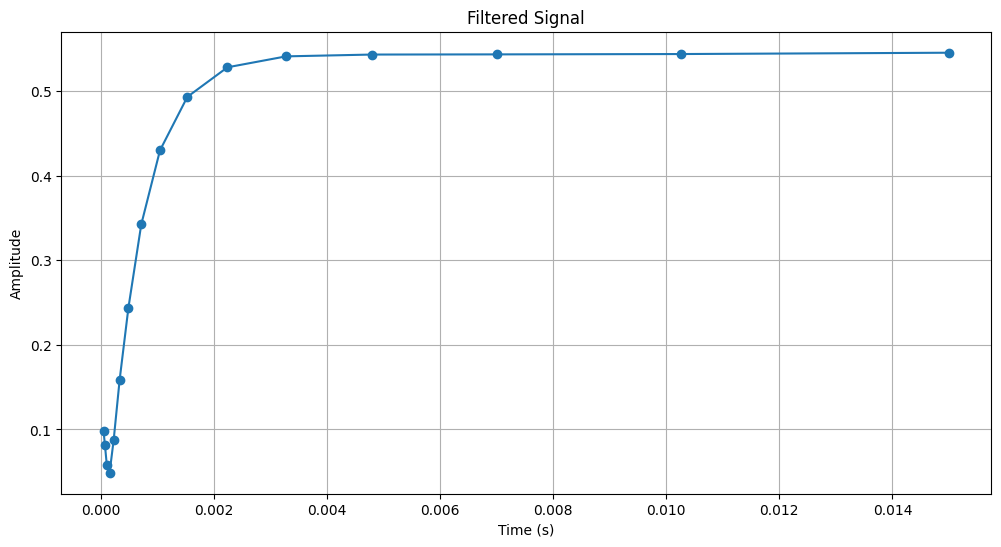

In [11]:
display_plot(signal_pack)

In [12]:
filteredsignal[:, 1]

array([0.09815775+0.j, 0.08180815+0.j, 0.05836746+0.j, 0.04879972+0.j,
       0.0875676 +0.j, 0.15899865+0.j, 0.24402158+0.j, 0.34247625+0.j,
       0.4300556 +0.j, 0.4933183 +0.j, 0.52829303+0.j, 0.54123342+0.j,
       0.54337472+0.j, 0.54357698+0.j, 0.54397602+0.j, 0.54553971+0.j])